# Notes On Streaming To Wit

### Some notes on my work concerning the real time streaming of audio from the pepper robot to Wit.ai to reduce lagging in conversation.

### audio interception:

By inheriting from the function 'alAudioDevices; I have been able to define a callback function that delivers a buffer in real time from peppers audio devices. As options are limited, we are using a single channel (the front pepper microphone) sampled at 16GHz. Audio frames/chunks are delivered in sizes of ~2500 samples. The audio is formatted as raw audio a hexadecimal byte-string. 

This audio can then be manipulated in real time (see below), and stored in a buffer to be used safely in multiple threading and streamed to an API. 
    

### streaming to wit:

The process of setting up the stream to Wit.ai has been highly frustrating as very little information is given by wit as to the format of stream that is accepted.

Wit.ai takes chunked data, (transfer-encoding must be set to 'chunked' in the POST header). Whilst it accepts streams in wav and ogg, both of which are supported by pepper. Headers of these files define file size/length and therefore are not considered as valid when processed real time. Simply: we don't know how long the file will be.

I succeeded finally by stream raw audio in peppers hexadecimal string (as apposed to a string of numeric values). Chunk sizes are also important and the wit servers seems to reject chunks that are too small: presumably high frequency requests are interpreted as spam, They also find it difficult to interpret requests that have large or uneven chunk sizes, returning a valid response but failing to process to audio that is given.   

Chunked data is supported in python via the requests module. A simple post request is made with a valid header and a generator function (an open generator function as apposed to a function pointer) in place of the data variable.


#### Streaming to other APIs 

As this technological space is still emerging It may be passable that in the future wit.ai might not continue to be the best service provider. 

Streaming to another provider could be passable by expanding the class and replacing the private 'stream_to_wit' function.

It might also be necessary to also override the generator function to support a new protocol

Both Google and Watson seem to use similar speech to text APIs and in the best case scenario adopting either wouldn't be too difficult 

### Audio processing possabilities

It is possible define a class that can perform real-time manipulation or analysis on the audio signal. Two possibilities are therefore shown.


Input can be analyzed: 

For example, a script could recognize the beginning and end of user speech through a simple analysis of noise levels and could dynamically organize wit requests. (this functionality is not supported current but could be relatively easy with some reorganization.


Input can be modified: 

One significant possibility could be to reduce noise levels in the signal, via gated noise filters and a band-pass filter in the vocal range. I can suppose that as the sample rate is considerably low (16GHZ) there will be considerable aliasing across all frequencies that might interfere with wits' speach-to-text 

### performence:

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
#averages:

ten_seconds_stream = [12.29, 12.98, 12.5, 12.28, 12.55, 
                       12.3, 12.7, 12.34, 12.51, 12.39,
                       14.64, 12.42, 12.49, 12.45, 12.51, 
                       12.49, 12.42, 12.39, 12.62, 12.50]

five_seconds_stream = [6.35, 6.46, 6.41, 6.31, 6.4,
                       6.38, 6.46, 6.43, 6.43, 6.44,
                       6.38, 6.39, 6.78, 6.41, 7.61,
                       8.86, 6.58, 6.81, 7.74, 6.37]

#averages:
avv_10_stream = 0
for val in ten_seconds_stream:
    avv_10_stream += (val / 20)
    
avv_5_stream = 0
for val in five_seconds_stream:
    avv_5_stream += (val / 20)

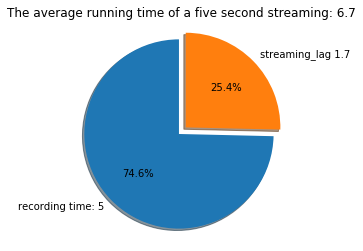

In [16]:
#5 second

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'recording time: 5', 'streaming_lag {}'.format(avv_5_stream - 5)
sizes = [5, avv_5_stream - 5]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("The average running time of a five second streaming: {}".format(avv_5_stream))
plt.show()

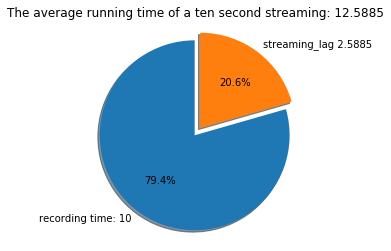

In [17]:
#10 second

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'recording time: 10', 'streaming_lag {}'.format(avv_10_stream - 10)
sizes = [10, avv_10_stream - 10]
explode = (0, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("The average running time of a ten second streaming: {}".format(avv_10_stream ))
plt.show()

#### samples from the old routine

In [18]:
ten_seconds = (8.2 + 6.7 + 6.9 + 9.2 + 7.3 + 8.0) / 6
five_seconds = (3.3 + 4.2) / 2

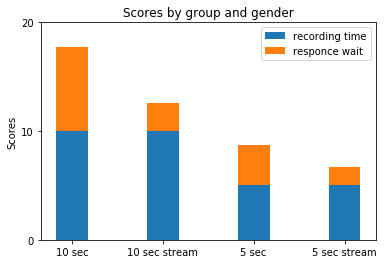

In [20]:
import numpy as np

N = 4
menMeans = (10, 10, 5, 5)
womenMeans = (ten_seconds, avv_10_stream-10, five_seconds, avv_5_stream-5)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('10 sec', '10 sec stream', '5 sec', '5 sec stream'))
plt.yticks(np.arange(0, 22, 10))
plt.legend((p1[0], p2[0]), ('recording time', 'responce wait'))

plt.show()

There is roughly a 50 percent decrese in latency in using the wit api

Improvment is more stark with longer recordings, this is presumably due to the speed in the conection